In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure

# Loading images and viewing defects

## Loading images
### ImageLoader init

        :param shuffle: Shuffle the samples before
        :param defect_class: 
            None -> all defect classes. 
            List -> ['FrontGridInterruption', 'Closed'], just these classes. 
            string -> 'FrontGridInterruption', one class. Applicable only to << operator

Usage
```python
    img = ImageLoader()
    img.load_n(n=10)  # Loads 10 images of the all classes
    img.load_n(n=10, defect_classes)  # Same as shown in the param defect_class
    # Shift left operator as shown below
````

In [ ]:
# Load 10 images of class 'FrontGridInterruption'
n_samples = 3  # Number of samples of images
image_df = ImageLoader(defect_class='FrontGridInterruption') << n_samples  # Load n_sample images of class 'FrontGridInterruption'

## Viewing defects
### DefectViewer init
        :param il_obj: Object of ImageLoader. Default(None)
        :param resize_shape: Shape to resize the images when Default(224, 224)
Usage
```python
    img = ImageLoader()
    img.load_n(n=10)  # Loads 10 images of the all classes
    
    dv = DefectViewer(img)
    dv.view_defects(sample_df=None, group_by='defect_class', annotation_type='segmentations')
    # Shift left operator as shown below
````

In [ ]:
# Get n_samples of the defect type 'FrontGridInterruption' and return an image array
images = DefectViewer() << image_df

# FFT and inverse

## Performing an FFT
### FFT init
        :param dim:
        :param axis: Which dimension(s) to perform FFT on. 
                When dim is 2 then axis should be a tuple. Default is the last two dimensions. 
                When dim is 1 then axis should be an integer dimension.
        :param return_which: 
                If 'both' (default) then returns (orig_img, magnitude, phase). 
                If 'magnitude' then return only (orig_img, , magnitude). 
                If 'phase' then return only (orig_img, , phase)
Usage
```python
    fft = FFT()
    fft.fft2(images)  # Performs 2D FFT and returns orgin images, magnitude and pahse
    
    # Shift left operator as shown below
````

In [ ]:
# FFT the images and get a tuple (original_img, magnitude and phase)
fft_images = FFT(dim=2) << images

## Displaying/Save Images
### Show init
        :param save_filename: Filename to save the output
        :param do_show: Display a plot or not
Usage
```python
    show = Show()
    show.show(images)
    
    # Shift left operator as shown below
````

In [ ]:
# Display the images
fft_images = Show(do_show=True) << fft_images

## Inverse FFT
### IFFT init
        :param mask: A mask for masking out the amplitude
Usage
```python
    ifft = IFFT()
    ifft.ifft(fft_images)
    
    # Shift left operator as shown below
````

In [ ]:
inv_images = IFFT() << fft_images

### FFT and inverse performance

In [ ]:
%matplotlib inline
start = time.perf_counter()
n_samples = 1000 

images = (IFFT() << (FFT(dim=2) << (DefectViewer() << (ImageLoader(defect_class='FrontGridInterruption') << n_samples))))
print(time.perf_counter()-start)

# Putting it all together as one pipe

### Read from left to right
#### 1. Load n_samples of defect_class
#### 2. Load the images associated with it
#### 3. Perform an FFT on the data
#### 4. Save it to file FFT and do not display it
#### 5. Perform an inverse FFT without a mask
#### 6. Save an file inverse FFFt and display to screen

In [ ]:
%matplotlib inline
n_samples = 3 
images = Show('inv_fft', do_show=True) << (IFFT() << (Show('fft', do_show=True) << (FFT(dim=2) << (DefectViewer() << (ImageLoader(defect_class='FrontGridInterruption') << n_samples)))))

# Creating and applying kernels

In [11]:
n_samples = 3
images = DefectViewer() << (ImageLoader(defect_class='FrontGridInterruption') << n_samples)

### Create a 2D gaussian kernel with size = 3 and std=8
### Convole with image: Note it returns both orignal images and filtered images (orig, filtered)
### Show (original and filtered)

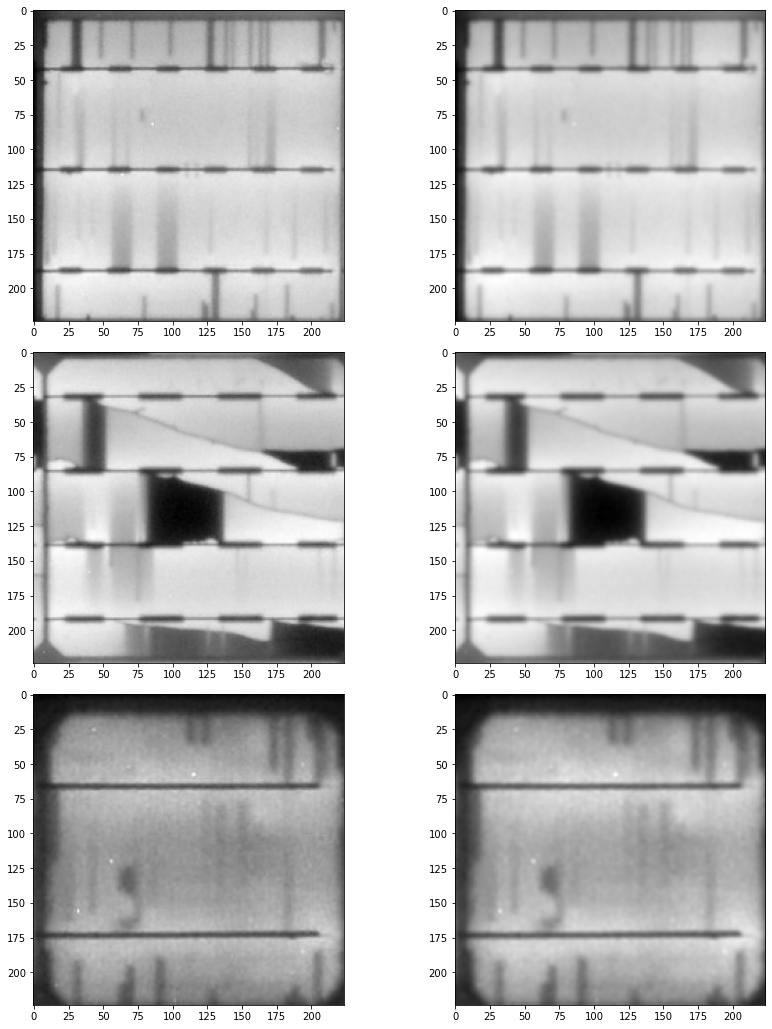

In [14]:
c_imgs = (Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=3, std=8) << images))
_ = Show('2dgaussian', do_show=True) << c_imgs

### Create and convolve a 1D gaussian kernel with size = 3 and std=8 and convolve along X direction

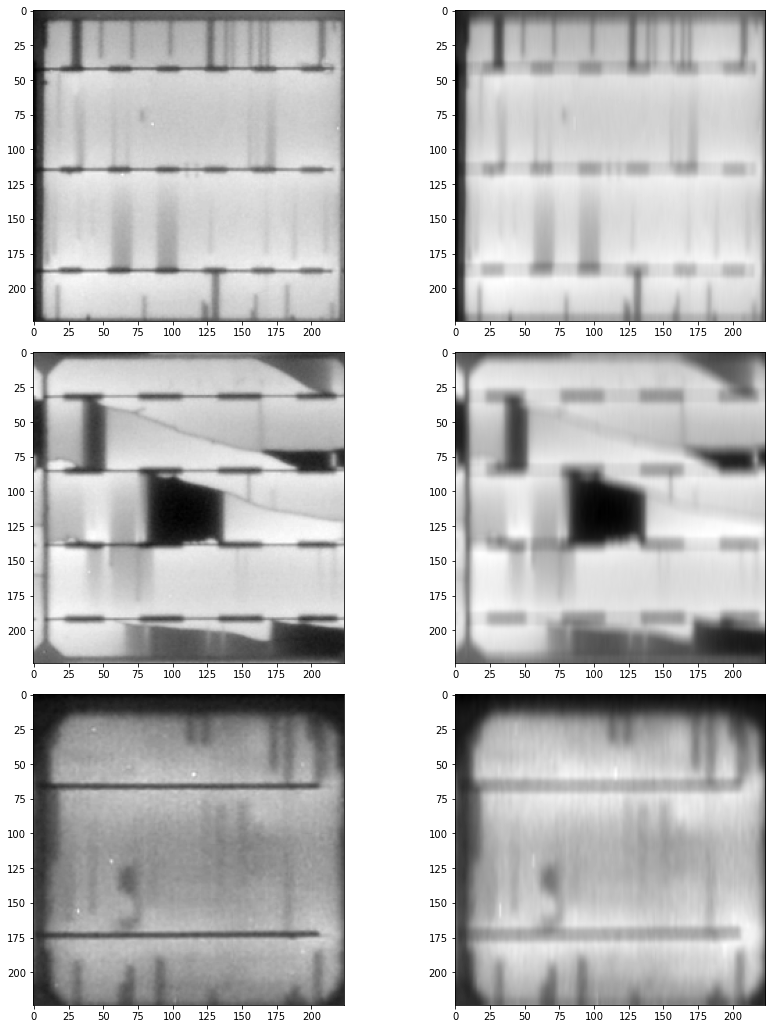

In [15]:
c_imgs = Convolve(axis=-2) << (CreateKernel(dim=1, kernel='gaussian', size=10, std=8) << images)
_ = Show('1dgaussian_x', do_show=True) << c_imgs

### Create and convolve a 1D gaussian kernel with size = 3 and std=8 and convolve along Y direction

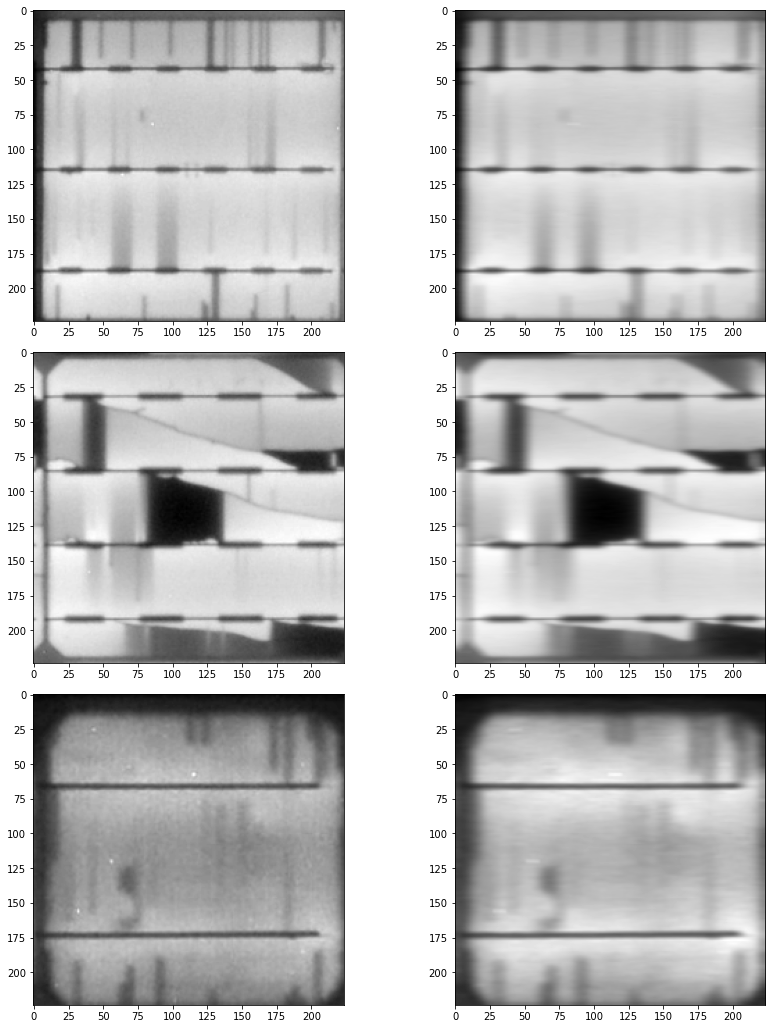

In [16]:
c_imgs = Convolve(axis=-1) << (CreateKernel(dim=1, kernel='gaussian', size=10, std=8) << images)
_ = Show('1dgaussian_y', do_show=True) << c_imgs

### Create and convolve a soble along x direction

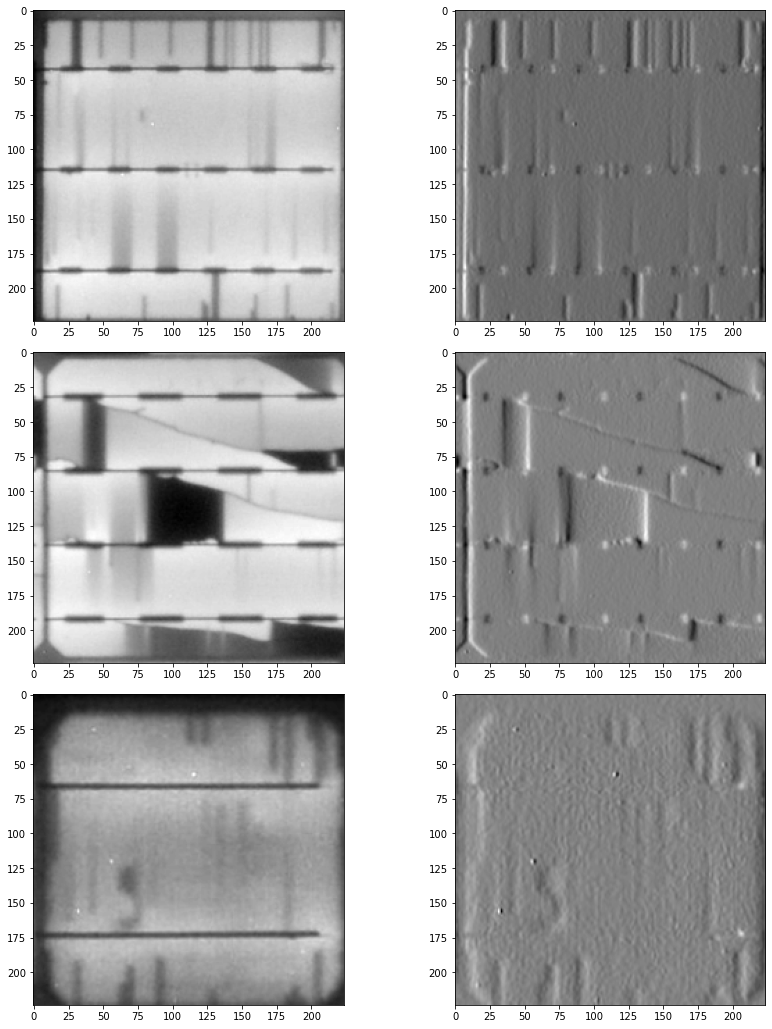

In [22]:
c_imgs = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=0) << images)
_ = Show('sobel', do_show=True) << c_imgs

### Create and convolve a soble along y direction

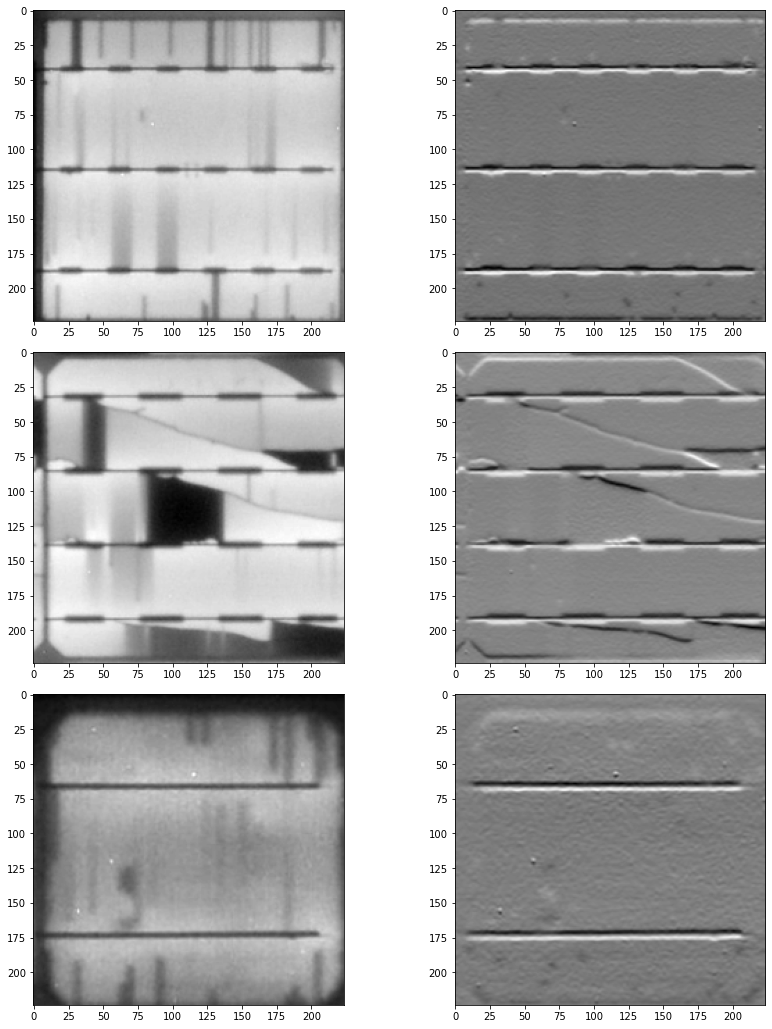

In [24]:
c_imgs = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='sobel', axis=1) << images)
_ = Show('sobel', do_show=True) << c_imgs

### Create and convolve a prewitt

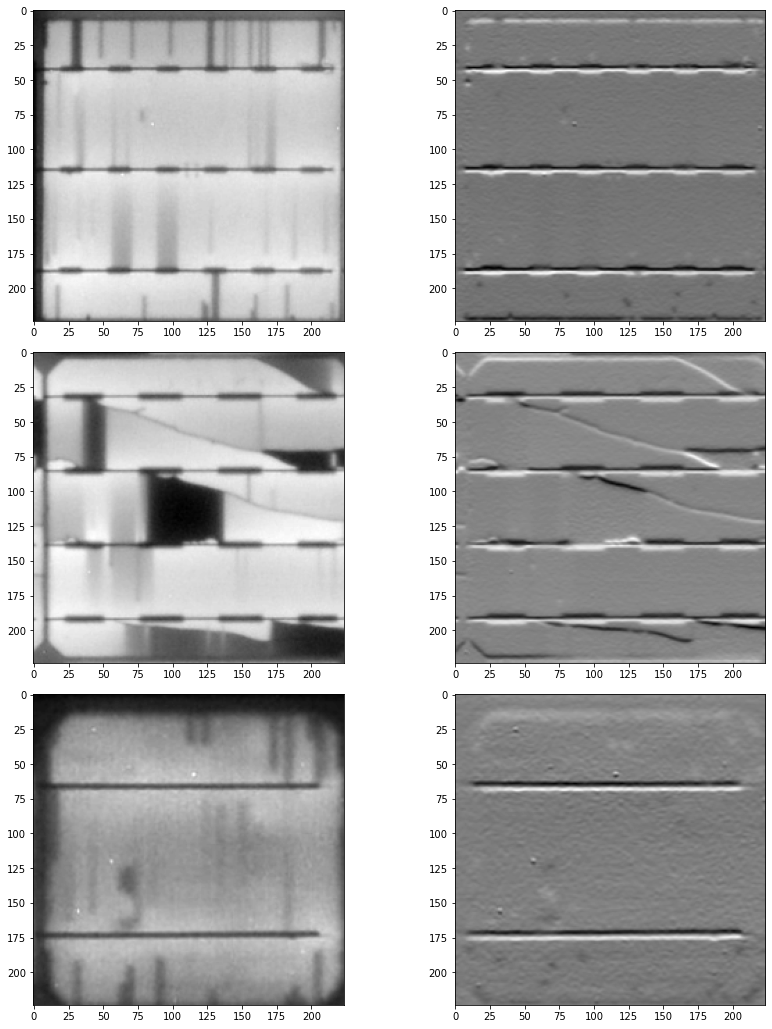

In [26]:
c_imgs = Convolve(axis=-2) << (CreateKernel(dim=2, kernel='prewitt', axis=1) << images)
_ = Show('prewitt', do_show=True) << c_imgs

## Applying Canny and HOG

### Applying canny

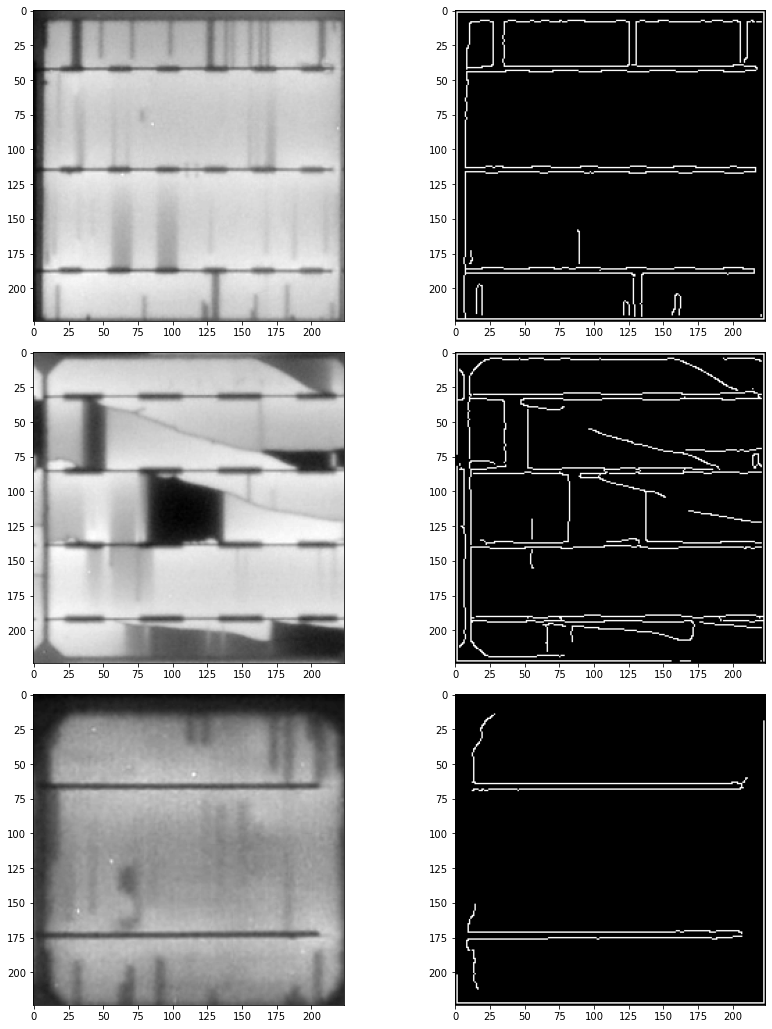

In [36]:
_ = Show('canny', do_show=True) << (Canny(sigma=1) <<  images)

### Applying HOG

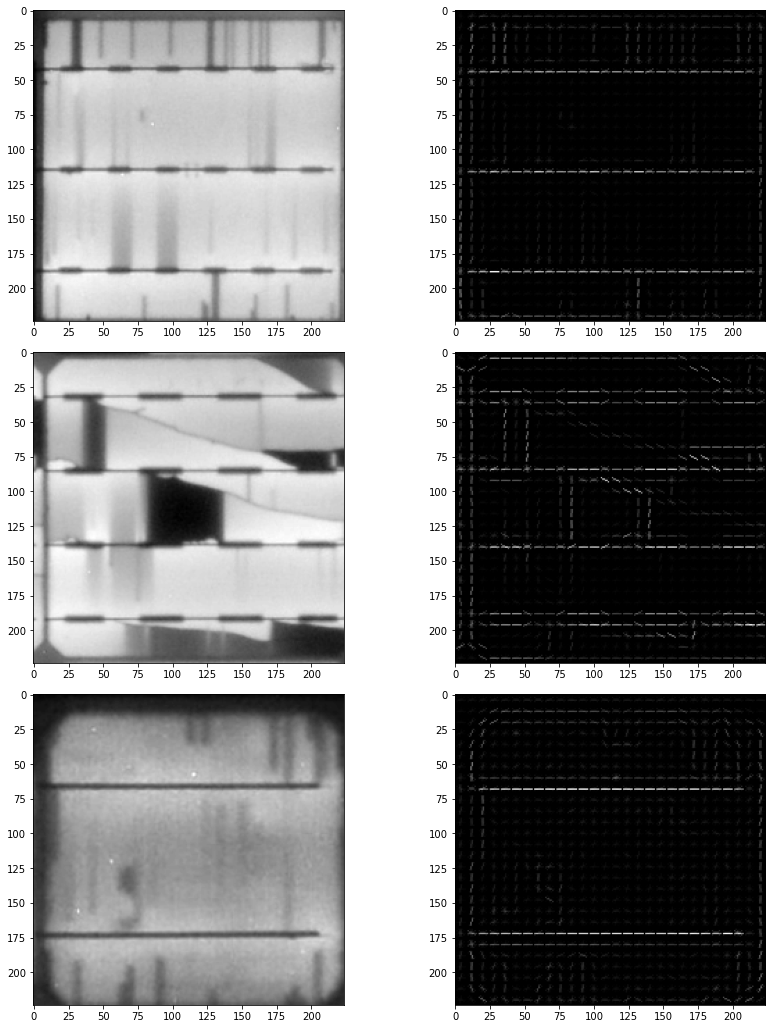

In [37]:
_ = Show('hog', do_show=True) << (HOG() <<  images)

# Applying exposure functions

In [ ]:
n_samples = 3
images = DefectViewer() << (ImageLoader(defect_class='FrontGridInterruption') << n_samples)

## Contrast stretching

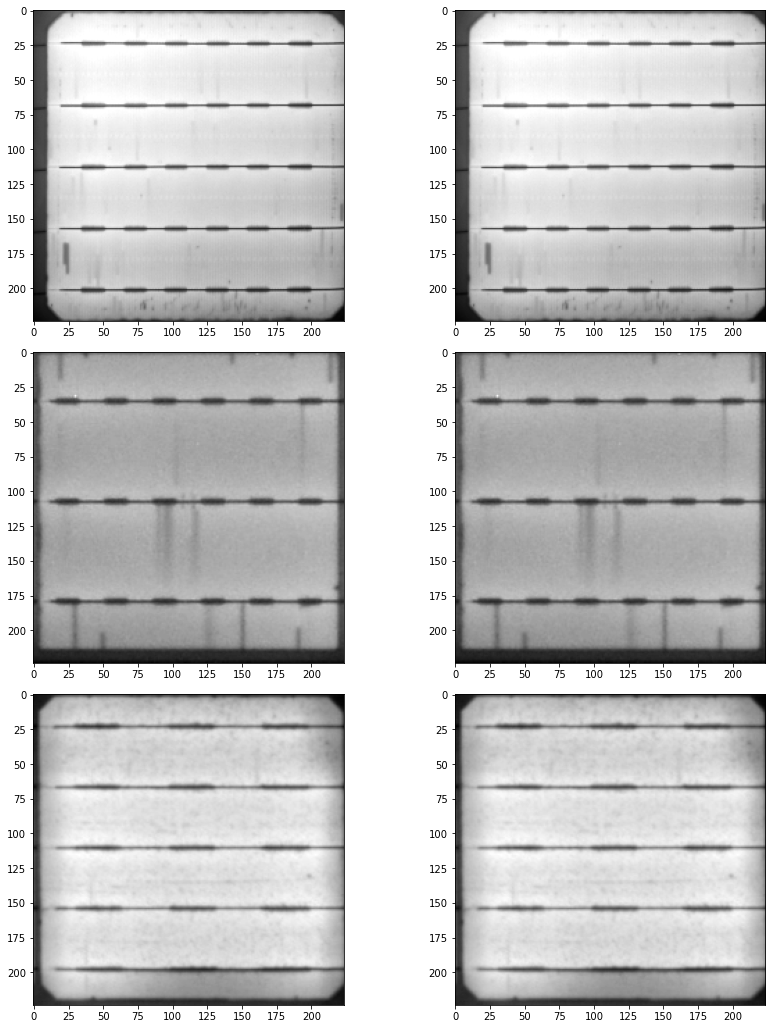

In [41]:
_ = Show('contrast_stretch') << (Exposure(mode='stretch') << images)

## Histogram equalization

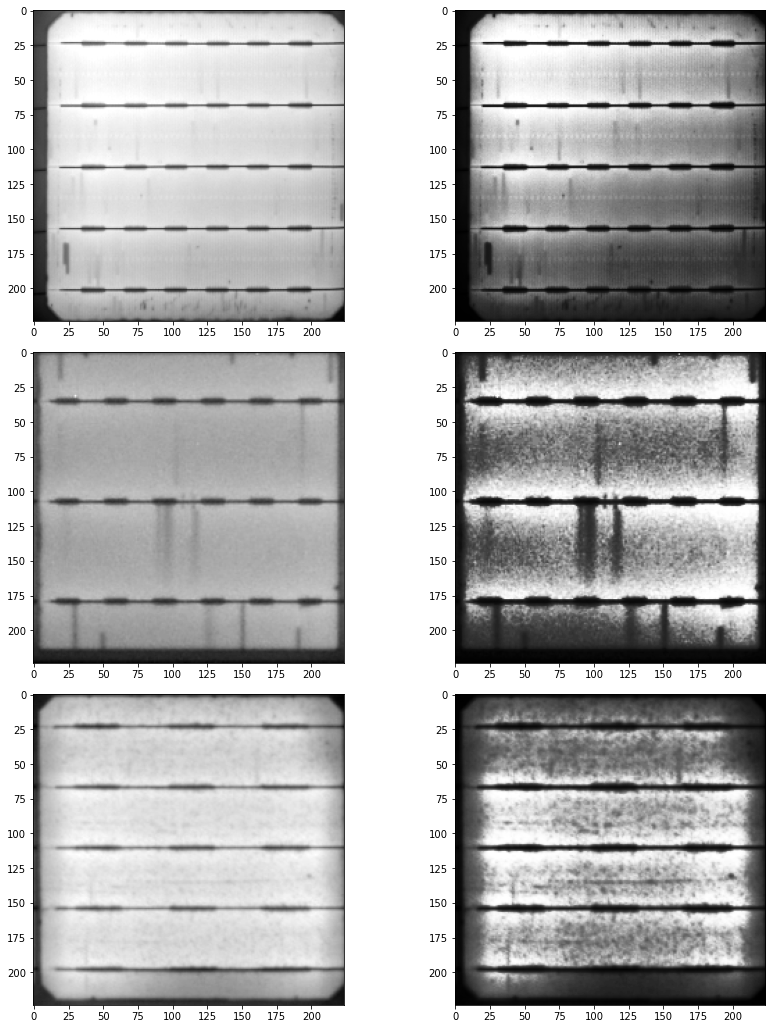

In [43]:
_ = Show('histoequ') << (Exposure(mode='histo') << images)

### Adaptive Histogram

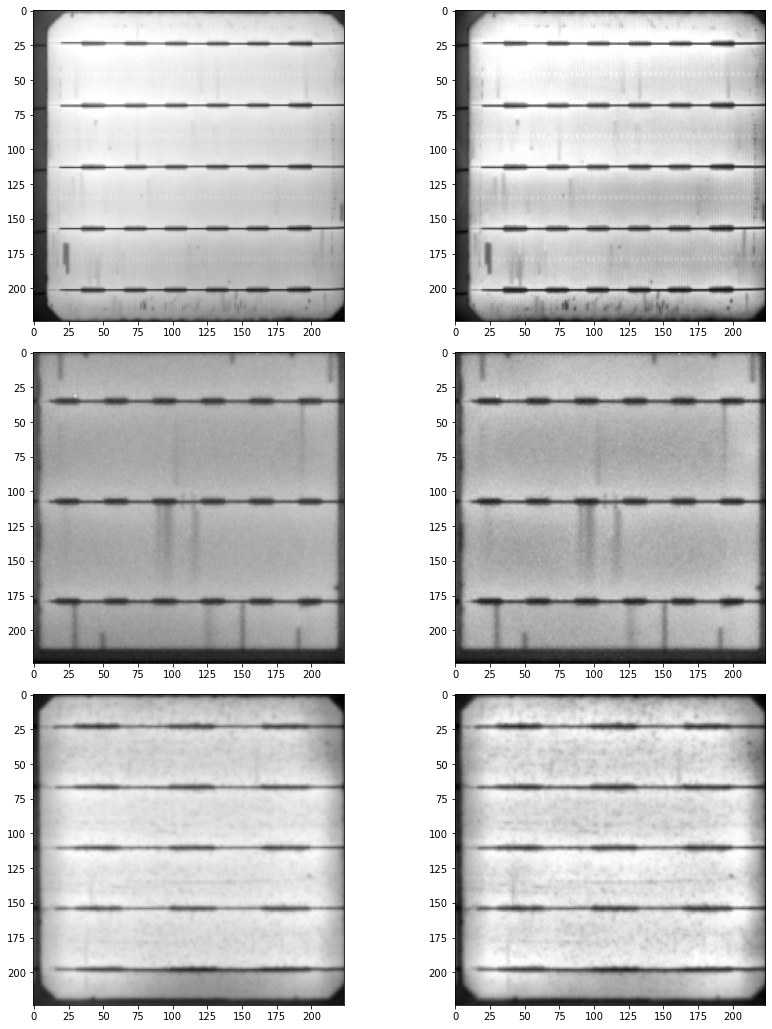

In [45]:
_ = Show('adaptive_histoequ') << (Exposure(mode='adaptive') << images)

## Sigmoid

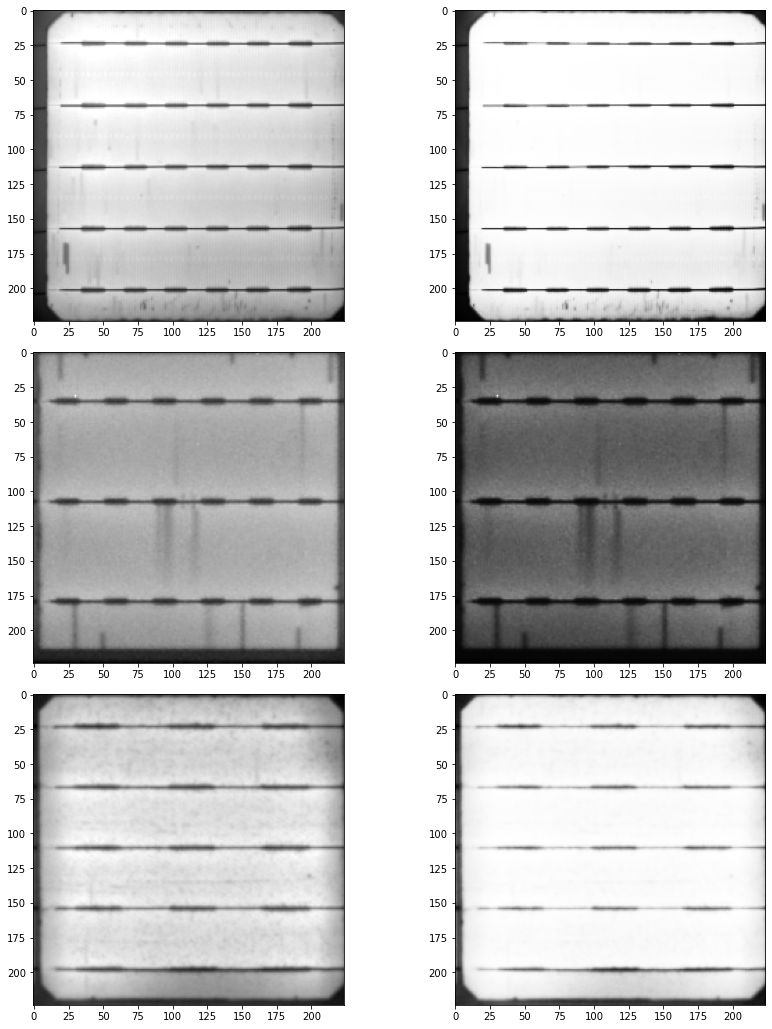

In [47]:
_ = Show('sigmoid') << (Exposure(mode='sigmoid') << images)

## Inverse Sigmoid

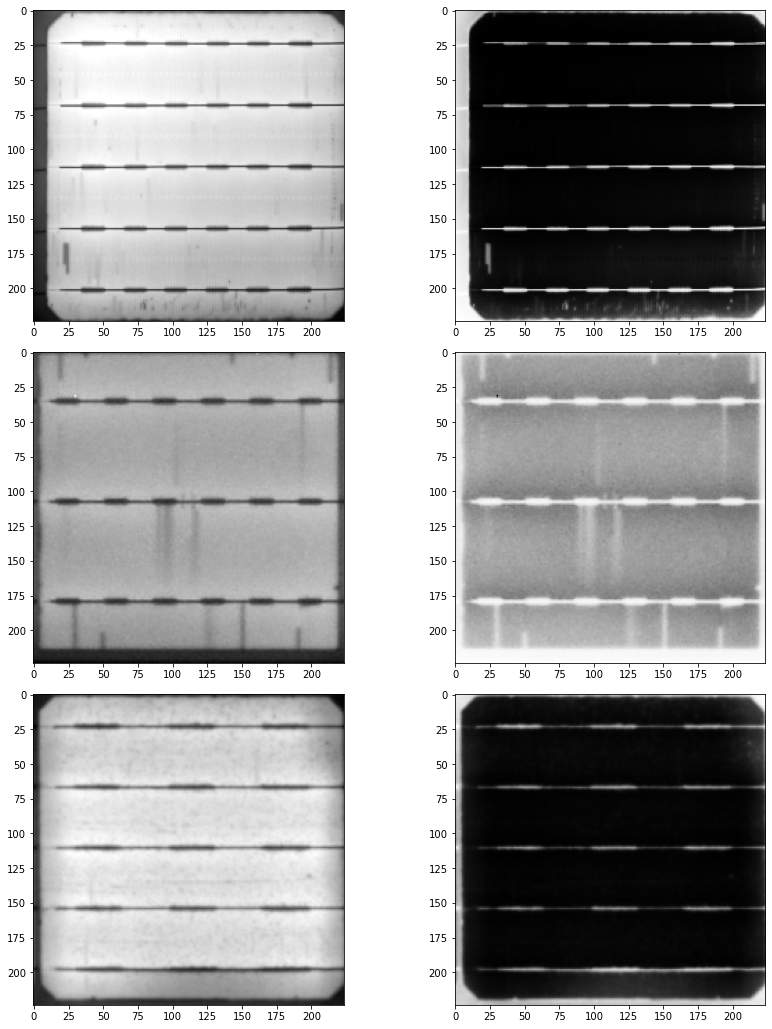

In [48]:
_ = Show('sigmoid') << (Exposure(mode='sigmoid', inverse=True) << images)

## Gamma

In [ ]:
_ = Show('gamma') << (Exposure(mode='gamma', gamma=0.2) << images)